# 1. Data Loading

In [1]:
from processing import *
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import tensorflow as tf
import sys
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, BatchNormalization, ReLU, GlobalAveragePooling1D, MaxPooling1D 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models

# MODE = 0            # ALL_LABEL_ALL_SENSOR
# MODE = 1            # ALL_LABEL_LOWER_SENSOR
# MODE = 2            # ALL_LABEL_UPPER_SENSOR
# MODE = 3            # Transient_LABEL_ALL_SENSOR
# MODE = 4            # Transient_LABEL_ALL_SENSOR_NO_STOPWALKING
# MODE = 5            # Transient_LABEL_LOWER_SENSOR
# MODE = 6            # Transient_LABEL_UPPER_SENSOR
# MODE = 7            # Add "Start Walking" 
MODE = 8          # Transient_LABEL_ALL_SENSOR_WITH_VELOCITY

Model = 0           # LSTM  (0.9333)
# Model = 1           # CNN (0.9120)
# Model = 2           # TCN (0.9133)
# Model = 3           # LSTM + CNN (0.9593)
# Model = 4           # CNN + LSTM 
# Model = 5           # Transformer

# IMU_MODE = 0             # Quaternion
IMU_MODE = 1             # Euler Angle
# IMU_MODE = 2             # 6D Representation


folder_paths = ['DataFile/data_250612', 'DataFile/data_250616', 'DataFile/data_250618']
all_trials = []

for folder_path in folder_paths:
    trials = Load_files(folder_path, pattern='cropped_*.h5')
    trials = [trial for trial in trials if 'test' not in trial['file']]     # Temporary remove Test set
    all_trials.extend(trials)

## Labeling ##
for trial in all_trials:
    trial['label'] = Generate_labels(trial)
    Convert_labels_to_int(trial, phase_to_int)

## EMG filtering ##
all_trials = process_all_emg(all_trials, lpf_fc=20, norm_method='max')

trial_num = len(all_trials)
print(f"Total trials: {trial_num}")

Total 4 files are now loaded...
Total 98 trials are completely loaded !!
Total 5 files are now loaded...
Total 145 trials are completely loaded !!
Total 5 files are now loaded...
Total 200 trials are completely loaded !!
Total trials: 443


# IMU Quaternion Calibration

In [2]:
for trial in all_trials:
    if (IMU_MODE == 0):
        # CalibrateIMU(trial)
        # CalibrateIMU_2(trial)
        CalibrateIMU_3(trial)
    elif (IMU_MODE == 1):
        # CalibrateIMU_5(trial)
        # CalibrateIMU_6(trial)
        # CalibrateIMU_7(trial)
        CalibrateIMU_vel(trial)
    elif (IMU_MODE == 2):
        CalibrateIMU_4(trial)

Visualization of Quaternion / Euler Angle / 6D Rotation

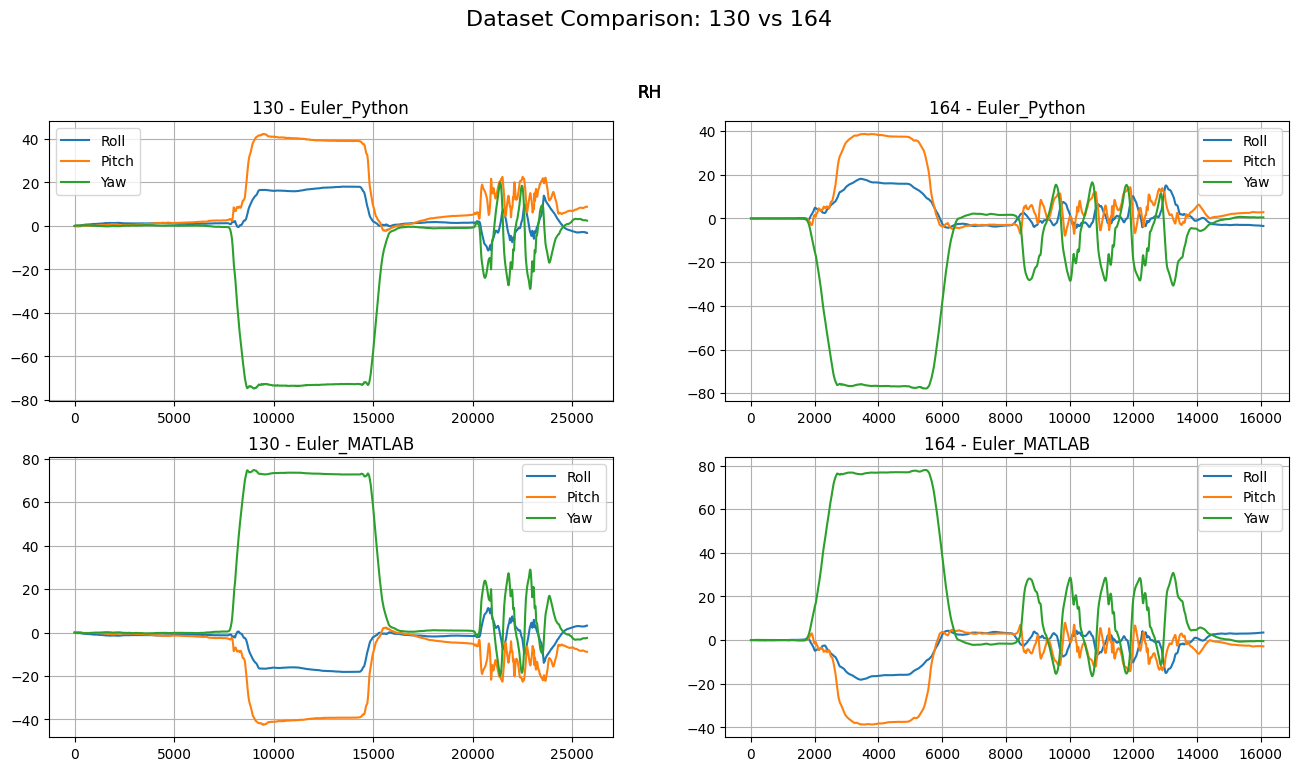

In [3]:
import random

idx1 = random.randint(0, trial_num-1) 
idx2 = random.randint(0, trial_num-1)  
while idx2 == idx1:
    idx2 = random.randint(0, trial_num-1)

# idx1 = 93
# idx2 = 56

IMU_SEL = 'imu1'

if (IMU_SEL == 'imu1'):
    EULER_SEL = 'rhip'
    NAME = 'RH'
elif (IMU_SEL == 'imu2'):
    EULER_SEL = 'rknee'
    NAME = 'RK_vel'
elif (IMU_SEL == 'imu3'):
    EULER_SEL = 'lhip'
    NAME = 'LH_vel'
elif (IMU_SEL == 'imu4'):
    EULER_SEL = 'lknee'
    NAME = 'LK_vel'
elif (IMU_SEL == 'imu5'):
    EULER_SEL = 'trunk'
    NAME = 'Pelvis_vel'
elif (IMU_SEL == 'imu6'):
    EULER_SEL = 'trunk'
    NAME = 'Trunk_vel'
elif (IMU_SEL == 'imu7'):
    EULER_SEL = 'rshoulder'
    NAME = 'RS_vel'
elif (IMU_SEL == 'imu8'):
    EULER_SEL = 'relbow'
    NAME = 'RE_vel'
elif (IMU_SEL == 'imu9'):
    EULER_SEL = 'lshoulder'
    NAME = 'LS_vel'
elif (IMU_SEL == 'imu10'):
    EULER_SEL = 'lelbow'
    NAME = 'LE_vel'


### Quaternion ###
if (IMU_MODE == 0):
    plt.figure(figsize=(16,6))

    plt.subplot(1, 2, 1)
    plt.plot(all_trials[idx1]['time'], all_trials[idx1][IMU_SEL][:, 0], label='w')
    plt.plot(all_trials[idx1]['time'], all_trials[idx1][IMU_SEL][:, 1], label='x')
    plt.plot(all_trials[idx1]['time'], all_trials[idx1][IMU_SEL][:, 2], label='y')
    plt.plot(all_trials[idx1]['time'], all_trials[idx1][IMU_SEL][:, 3], label='z')
    plt.figtext(0.5, 0.91, NAME, fontsize=12, ha='center')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(all_trials[idx2]['time'], all_trials[idx2][IMU_SEL][:, 0], label='w')
    plt.plot(all_trials[idx2]['time'], all_trials[idx2][IMU_SEL][:, 1], label='x')
    plt.plot(all_trials[idx2]['time'], all_trials[idx2][IMU_SEL][:, 2], label='y')
    plt.plot(all_trials[idx2]['time'], all_trials[idx2][IMU_SEL][:, 3], label='z')
    plt.figtext(0.5, 0.91, NAME, fontsize=12, ha='center')
    plt.legend()
    plt.grid(True)

    plt.suptitle(f"Dataset Comparison: {idx1} vs {idx2}", fontsize=16, y=1.02)
    plt.show()


### Euler Angle ###
elif (IMU_MODE == 1):
    plt.figure(figsize=(16,8))

    plt.subplot(2, 2, 1)
    plt.plot(all_trials[idx1]['time'], all_trials[idx1][IMU_SEL][:, 0], label='Roll')
    plt.plot(all_trials[idx1]['time'], all_trials[idx1][IMU_SEL][:, 1], label='Pitch')
    plt.plot(all_trials[idx1]['time'], all_trials[idx1][IMU_SEL][:, 2], label='Yaw')
    plt.figtext(0.5, 0.91, NAME, fontsize=12, ha='center')
    plt.title(f"{idx1} - Euler_Python")
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 2, 2)
    plt.plot(all_trials[idx2]['time'], all_trials[idx2][IMU_SEL][:, 0], label='Roll')
    plt.plot(all_trials[idx2]['time'], all_trials[idx2][IMU_SEL][:, 1], label='Pitch')
    plt.plot(all_trials[idx2]['time'], all_trials[idx2][IMU_SEL][:, 2], label='Yaw')
    plt.figtext(0.5, 0.91, NAME, fontsize=12, ha='center')
    plt.title(f"{idx2} - Euler_Python")
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 2, 3)
    plt.plot(all_trials[idx1]['time'], all_trials[idx1][EULER_SEL][2, :], label='Roll')
    plt.plot(all_trials[idx1]['time'], all_trials[idx1][EULER_SEL][1, :], label='Pitch')
    plt.plot(all_trials[idx1]['time'], all_trials[idx1][EULER_SEL][0, :], label='Yaw')
    plt.figtext(0.5, 0.91, NAME, fontsize=12, ha='center')
    plt.title(f"{idx1} - Euler_MATLAB")
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 2, 4)
    plt.plot(all_trials[idx2]['time'], all_trials[idx2][EULER_SEL][2, :], label='Roll')
    plt.plot(all_trials[idx2]['time'], all_trials[idx2][EULER_SEL][1, :], label='Pitch')
    plt.plot(all_trials[idx2]['time'], all_trials[idx2][EULER_SEL][0, :], label='Yaw')
    plt.figtext(0.5, 0.91, NAME, fontsize=12, ha='center')
    plt.title(f"{idx2} - Euler_MATLAB")
    plt.legend()
    plt.grid(True)

    plt.suptitle(f"Dataset Comparison: {idx1} vs {idx2}", fontsize=16, y=1.02)
    plt.show()


### 6D Representation ###
elif (IMU_MODE == 2):
    plt.figure(figsize=(16,6))

    plt.subplot(1, 2, 1)
    plt.plot(all_trials[idx1]['time'], all_trials[idx1][IMU_SEL][:, 0], label='R1')
    plt.plot(all_trials[idx1]['time'], all_trials[idx1][IMU_SEL][:, 1], label='R2')
    plt.plot(all_trials[idx1]['time'], all_trials[idx1][IMU_SEL][:, 2], label='R3')
    plt.plot(all_trials[idx1]['time'], all_trials[idx1][IMU_SEL][:, 3], label='R4')
    plt.plot(all_trials[idx1]['time'], all_trials[idx1][IMU_SEL][:, 4], label='R5')
    plt.plot(all_trials[idx1]['time'], all_trials[idx1][IMU_SEL][:, 5], label='R6')
    plt.figtext(0.5, 0.91, NAME, fontsize=12, ha='center')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(all_trials[idx2]['time'], all_trials[idx2][IMU_SEL][:, 0], label='R1')
    plt.plot(all_trials[idx2]['time'], all_trials[idx2][IMU_SEL][:, 1], label='R2')
    plt.plot(all_trials[idx2]['time'], all_trials[idx2][IMU_SEL][:, 2], label='R3')
    plt.plot(all_trials[idx2]['time'], all_trials[idx2][IMU_SEL][:, 3], label='R4')
    plt.plot(all_trials[idx2]['time'], all_trials[idx2][IMU_SEL][:, 4], label='R5')
    plt.plot(all_trials[idx2]['time'], all_trials[idx2][IMU_SEL][:, 5], label='R6')
    plt.figtext(0.5, 0.91, NAME, fontsize=12, ha='center')
    plt.legend()
    plt.grid(True)

    plt.suptitle(f"Dataset Comparison: {idx1} vs {idx2}", fontsize=16, y=1.02)
    plt.show()

# Angular Velocity

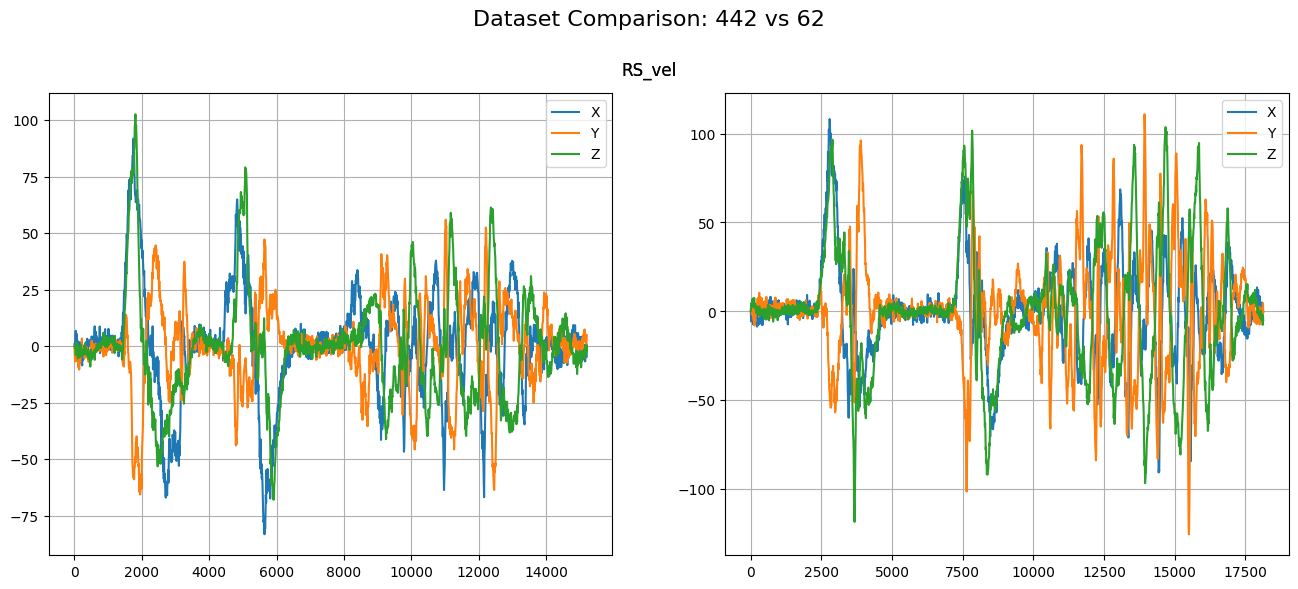

In [30]:
import random

idx1 = random.randint(0, trial_num-1) 
idx2 = random.randint(0, trial_num-1)  
while idx2 == idx1:
    idx2 = random.randint(0, trial_num-1)

# idx1 = 93
# idx2 = 56

IMU_SEL = 'imu7'

if (IMU_SEL == 'imu1'):
    EULER_VEL_SEL = 'imu1_vel'
    NAME = 'RH_vel'
elif (IMU_SEL == 'imu2'):
    EULER_VEL_SEL = 'imu2_vel'
    NAME = 'RK_vel'
elif (IMU_SEL == 'imu3'):
    EULER_VEL_SEL = 'imu3_vel'
    NAME = 'LH_vel'
elif (IMU_SEL == 'imu4'):
    EULER_VEL_SEL = 'imu4_vel'
    NAME = 'LK_vel'
elif (IMU_SEL == 'imu5'):
    EULER_VEL_SEL = 'imu5_vel'
    NAME = 'Pelvis_vel'
elif (IMU_SEL == 'imu6'):
    EULER_VEL_SEL = 'imu6_vel'
    NAME = 'Trunk_vel'
elif (IMU_SEL == 'imu7'):
    EULER_VEL_SEL = 'imu7_vel'
    NAME = 'RS_vel'
elif (IMU_SEL == 'imu8'):
    EULER_VEL_SEL = 'imu8_vel'
    NAME = 'RE_vel'
elif (IMU_SEL == 'imu9'):
    EULER_VEL_SEL = 'imu9_vel'
    NAME = 'LS_vel'
elif (IMU_SEL == 'imu10'):
    EULER_VEL_SEL = 'imu10_vel'
    NAME = 'LE_vel'



if (MODE == 8):
    plt.figure(figsize=(16,6))

    plt.subplot(1, 2, 1)
    plt.plot(all_trials[idx1]['time'], all_trials[idx1][EULER_VEL_SEL][:, 0], label='X')
    plt.plot(all_trials[idx1]['time'], all_trials[idx1][EULER_VEL_SEL][:, 1], label='Y')
    plt.plot(all_trials[idx1]['time'], all_trials[idx1][EULER_VEL_SEL][:, 2], label='Z')
    plt.figtext(0.5, 0.91, NAME, fontsize=12, ha='center')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(all_trials[idx2]['time'], all_trials[idx2][EULER_VEL_SEL][:, 0], label='X')
    plt.plot(all_trials[idx2]['time'], all_trials[idx2][EULER_VEL_SEL][:, 1], label='Y')
    plt.plot(all_trials[idx2]['time'], all_trials[idx2][EULER_VEL_SEL][:, 2], label='Z')
    plt.figtext(0.5, 0.91, NAME, fontsize=12, ha='center')
    plt.legend()
    plt.grid(True)

    plt.suptitle(f"Dataset Comparison: {idx1} vs {idx2}", fontsize=16, y=1.02)
    plt.show()

# Trunk (or Pelvis) Check

In [4]:
import random

idx1 = random.randint(0, trial_num-1) 
idx2 = random.randint(0, trial_num-1)  
while idx2 == idx1:
    idx2 = random.randint(0, trial_num-1)

# idx1 = 93
# idx2 = 56


### Quaternion ###
if (IMU_MODE == 0):
    plt.figure(figsize=(16,8))

    plt.subplot(1, 2, 1)
    plt.plot(all_trials[idx1]['time'], all_trials[idx1]['imu6'][:, 0], label='w')
    plt.plot(all_trials[idx1]['time'], all_trials[idx1]['imu6'][:, 1], label='x')
    plt.plot(all_trials[idx1]['time'], all_trials[idx1]['imu6'][:, 2], label='y')
    plt.plot(all_trials[idx1]['time'], all_trials[idx1]['imu6'][:, 3], label='z')
    plt.title(f"{idx1} - Trunk")
    plt.legend()
    plt.grid(True)


    plt.subplot(1, 2, 2)
    plt.plot(all_trials[idx2]['time'], all_trials[idx2]['imu6'][:, 0], label='w')
    plt.plot(all_trials[idx2]['time'], all_trials[idx2]['imu6'][:, 1], label='x')
    plt.plot(all_trials[idx2]['time'], all_trials[idx2]['imu6'][:, 2], label='y')
    plt.plot(all_trials[idx2]['time'], all_trials[idx2]['imu6'][:, 3], label='z')
    plt.title(f"{idx2} - Trunk")
    plt.legend()
    plt.grid(True)

    plt.suptitle(f"Dataset Comparison: {idx1} vs {idx2}", fontsize=16, y=1.02)
    plt.show()


### Euler Angle ###
elif (IMU_MODE == 1):
    plt.figure(figsize=(16,8))

    plt.subplot(1, 2, 1)
    plt.plot(all_trials[idx1]['time'], all_trials[idx1]['imu6'][:, 0], label='Roll')
    plt.plot(all_trials[idx1]['time'], all_trials[idx1]['imu6'][:, 1], label='Pitch')
    plt.plot(all_trials[idx1]['time'], all_trials[idx1]['imu6'][:, 2], label='Yaw')
    plt.title(f"{idx1} - Trunk _ Euler_Python")
    plt.legend()
    plt.grid(True)


    plt.subplot(1, 2, 2)
    plt.plot(all_trials[idx1]['time'], all_trials[idx1]['trunk'][2, :], label='Yaw')
    plt.plot(all_trials[idx1]['time'], all_trials[idx1]['trunk'][1, :], label='Pitch')
    plt.plot(all_trials[idx1]['time'], all_trials[idx1]['trunk'][0, :], label='Roll')
    plt.title(f"{idx1} - Trunk _ Euler_MATLAB")
    plt.legend()
    plt.grid(True)

    plt.suptitle("Dataset Comparison: Python vs MATLAB", fontsize=16, y=1.02)
    plt.show()

# Simple Check

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


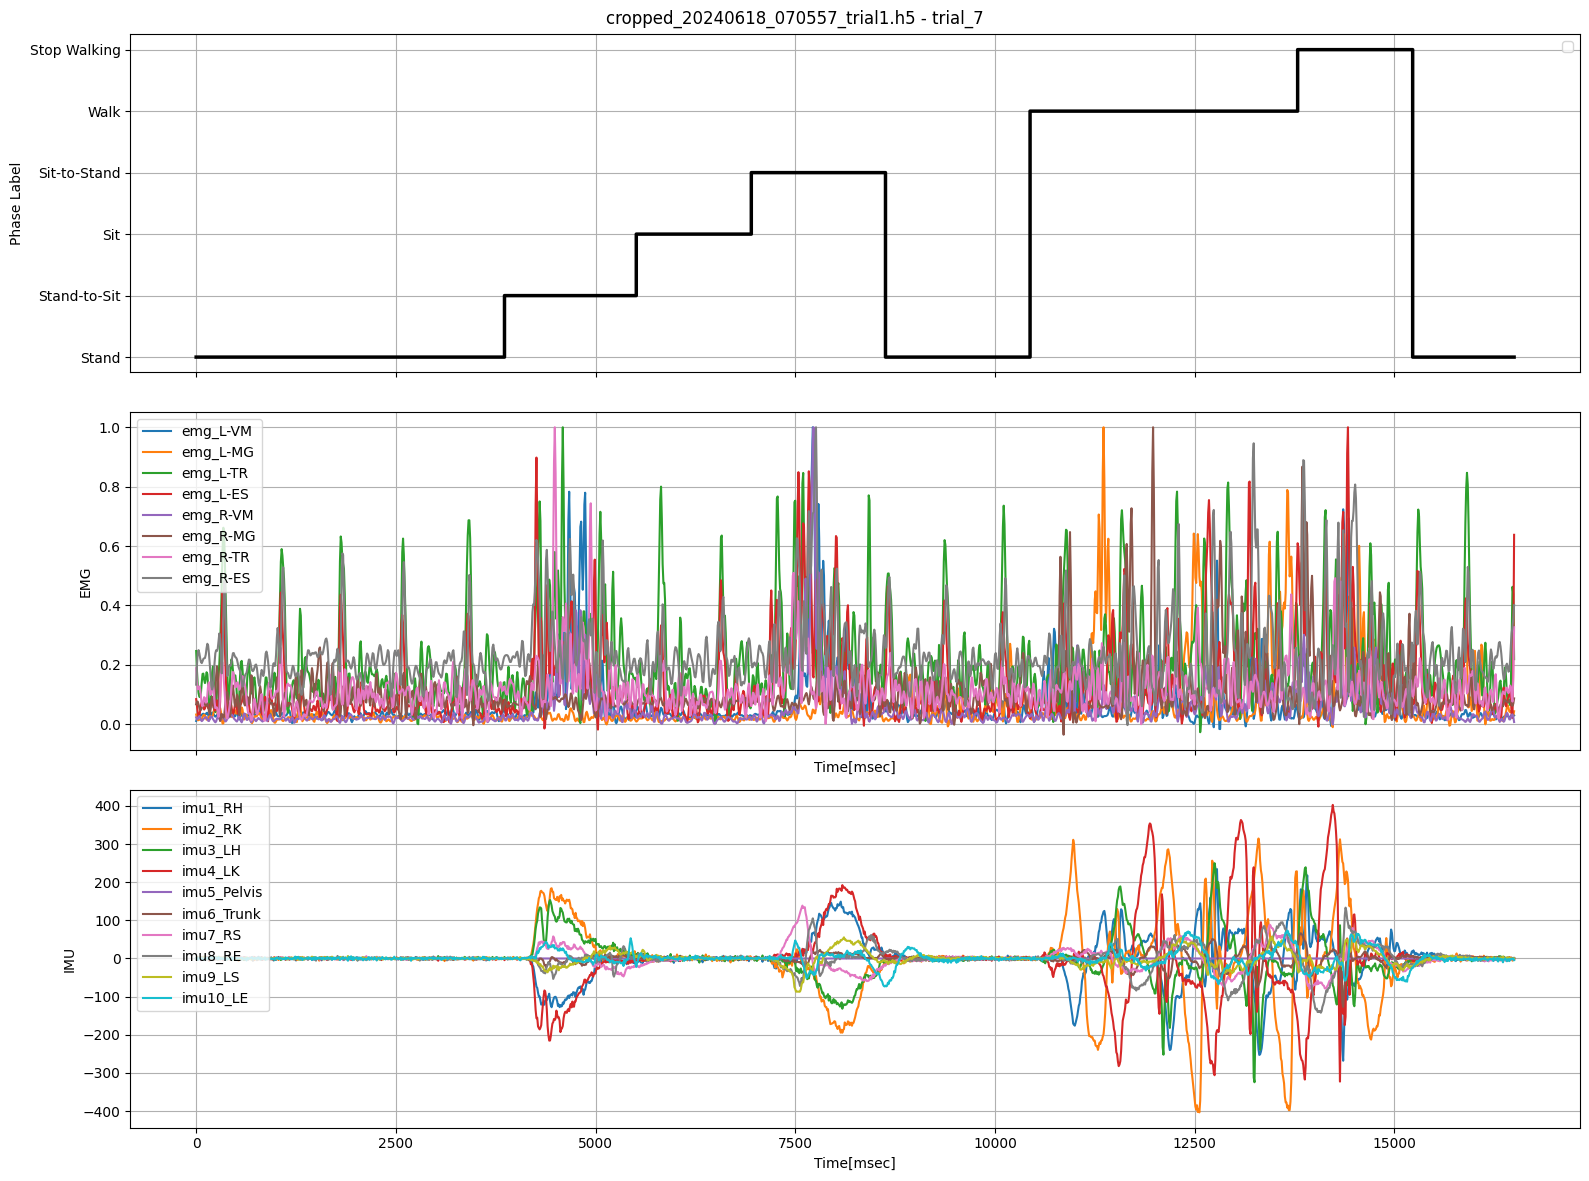

In [34]:
idx = 240    # Choose

trial = all_trials[idx]         # trial_1, trial_10, trial_2, ... 순이어서 [1] -> trial_10 데이터임
time = trial['time']
label_int = trial['label_int']
rising_ok = trial['rising_ok']
falling_ok = trial['falling_ok']

fig, axes = plt.subplots(3, 1, figsize=(16, 12), sharex=True)

# 위쪽: 라벨
axes[0].plot(time, trial['label_int'], drawstyle='steps-post', color='black', linewidth=2.5)
if (MODE == 0 or MODE == 1 or MODE == 2):
    axes[0].plot(time, rising_ok * max(trial['label_int']), linestyle='--', alpha=0.6, color='red', label='Labeling Start')
    axes[0].plot(time, falling_ok * max(trial['label_int']), linestyle='--', alpha=0.6, color='blue', label='Labeling Stop')
elif (MODE == 3):
    # 마스킹: rising_ok가 0인 부분은 NaN으로 처리
    rising_masked = np.where(rising_ok==1, max(trial['label_int']), 0)
    falling_masked = np.where(falling_ok==1, max(trial['label_int']), 0)
    axes[0].plot(time, rising_masked, linestyle='--', alpha=0.6, color='red', label='Labeling Start')
    axes[0].plot(time, falling_masked, linestyle='--', alpha=0.6, color='blue', label='Labeling Stop')

axes[0].set_yticks(list(phase_to_int.values()))
axes[0].set_yticklabels(list(phase_to_int.keys()))
axes[0].set_ylabel("Phase Label")
axes[0].legend(loc='upper right')
axes[0].grid(True)


# 중간: EMG
if (MODE == 0 or MODE == 3 or MODE == 4 or MODE == 7 or MODE == 8):
    axes[1].plot(time, trial['emgL1_norm'], label='emg_L-VM')
    axes[1].plot(time, trial['emgL2_norm'], label='emg_L-MG')
    axes[1].plot(time, trial['emgL3_norm'], label='emg_L-TR')
    axes[1].plot(time, trial['emgL4_norm'], label='emg_L-ES')
    axes[1].plot(time, trial['emgR1_norm'], label='emg_R-VM')
    axes[1].plot(time, trial['emgR2_norm'], label='emg_R-MG')
    axes[1].plot(time, trial['emgR3_norm'], label='emg_R-TR')
    axes[1].plot(time, trial['emgR4_norm'], label='emg_R-ES')
elif (MODE == 1 or MODE == 5):
    axes[1].plot(time, trial['emgL1_norm'], label='emg_L-VM')
    axes[1].plot(time, trial['emgL2_norm'], label='emg_L-MG')
    axes[1].plot(time, trial['emgR1_norm'], label='emg_R-VM')
    axes[1].plot(time, trial['emgR2_norm'], label='emg_R-MG')
elif (MODE == 2 or MODE == 6):
    axes[1].plot(time, trial['emgL3_norm'], label='emg_L-TR')
    axes[1].plot(time, trial['emgL4_norm'], label='emg_L-ES')
    axes[1].plot(time, trial['emgR3_norm'], label='emg_R-TR')
    axes[1].plot(time, trial['emgR4_norm'], label='emg_R-ES')
axes[1].set_ylabel("EMG")
axes[1].set_xlabel("Time[msec]")
axes[1].legend()
axes[1].grid(True)

# 아래쪽: IMU
if (MODE == 0 or MODE == 3 or MODE == 4 or MODE == 7):
    axes[2].plot(time, trial['imu1'][:,3], label='imu1_RH')
    axes[2].plot(time, trial['imu2'][:,3], label='imu2_RK')
    axes[2].plot(time, trial['imu3'][:,3], label='imu3_LH')
    axes[2].plot(time, trial['imu4'][:,3], label='imu4_LK')
    axes[2].plot(time, trial['imu5'][:,3], label='imu5_Pelvis')
    axes[2].plot(time, trial['imu6'][:,3], label='imu6_Trunk')
    axes[2].plot(time, trial['imu7'][:,3], label='imu7_RS')
    axes[2].plot(time, trial['imu8'][:,3], label='imu8_RE')
    axes[2].plot(time, trial['imu9'][:,3], label='imu9_LS')
    axes[2].plot(time, trial['imu10'][:,3], label='imu10_LE')
elif (MODE == 1 or MODE == 5):
    axes[2].plot(time, trial['imu1'][:,3], label='imu1_RH')
    axes[2].plot(time, trial['imu2'][:,3], label='imu2_RK')
    axes[2].plot(time, trial['imu3'][:,3], label='imu3_LH')
    axes[2].plot(time, trial['imu4'][:,3], label='imu4_LK')
    axes[2].plot(time, trial['imu5'][:,3], label='imu5_Pelvis')
    axes[2].plot(time, trial['imu6'][:,3], label='imu6_Trunk')
elif (MODE == 2 or MODE == 6):
    axes[2].plot(time, trial['imu5'][:,3], label='imu5_Pelvis')
    axes[2].plot(time, trial['imu6'][:,3], label='imu6_Trunk')
    axes[2].plot(time, trial['imu7'][:,3], label='imu7_RS')
    axes[2].plot(time, trial['imu8'][:,3], label='imu8_RE')
    axes[2].plot(time, trial['imu9'][:,3], label='imu9_LS')
    axes[2].plot(time, trial['imu10'][:,3], label='imu10_LE')
elif (MODE == 8):
    axes[2].plot(time, trial['imu1_vel'][:,2], label='imu1_RH')
    axes[2].plot(time, trial['imu2_vel'][:,2], label='imu2_RK')
    axes[2].plot(time, trial['imu3_vel'][:,2], label='imu3_LH')
    axes[2].plot(time, trial['imu4_vel'][:,2], label='imu4_LK')
    axes[2].plot(time, trial['imu5_vel'][:,2], label='imu5_Pelvis')
    axes[2].plot(time, trial['imu6_vel'][:,2], label='imu6_Trunk')
    axes[2].plot(time, trial['imu7_vel'][:,2], label='imu7_RS')
    axes[2].plot(time, trial['imu8_vel'][:,2], label='imu8_RE')
    axes[2].plot(time, trial['imu9_vel'][:,2], label='imu9_LS')
    axes[2].plot(time, trial['imu10_vel'][:,2], label='imu10_LE')
axes[2].set_ylabel("IMU")
axes[2].set_xlabel("Time[msec]")
axes[2].legend(loc='upper left')
axes[2].grid(True)


plt.suptitle(f"{trial['file']} - {trial['trial']}")
plt.tight_layout()
plt.show()

In [35]:
trial_keys = [(trial_data['file'], trial_data['trial']) for trial_data in all_trials]      # (filename, trial_number) 형태
trial_dict = {k: t for k, t in zip(trial_keys, all_trials)}                                # {(filename, trial_number): trial_data, ...} 형태
if (MODE == 0 or MODE == 3 or MODE == 4 or MODE == 7):
    input_keys = ['emgL1_norm','emgL2_norm','emgL3_norm','emgL4_norm', 'emgR1_norm','emgR2_norm','emgR3_norm','emgR4_norm', 'imu1', 'imu2', 'imu3', 'imu4', 'imu5', 'imu6', 'imu7', 'imu8', 'imu9', 'imu10']
elif (MODE == 1 or MODE == 5):
    input_keys = ['emgL1_norm','emgL2_norm', 'emgR1_norm','emgR2_norm', 'imu1', 'imu2', 'imu3', 'imu4', 'imu5', 'imu6']
elif (MODE == 2 or MODE == 6):
    input_keys = ['emgL3_norm','emgL4_norm', 'emgR3_norm','emgR4_norm', 'imu5', 'imu6', 'imu7', 'imu8', 'imu9', 'imu10']
elif (MODE == 8):
    input_keys = ['emgL1_norm','emgL2_norm','emgL3_norm','emgL4_norm', 'emgR1_norm','emgR2_norm','emgR3_norm','emgR4_norm', 
                  'imu1', 'imu2', 'imu3', 'imu4', 'imu5', 'imu6', 'imu7', 'imu8', 'imu9', 'imu10',
                  'imu1_vel', 'imu2_vel', 'imu3_vel', 'imu4_vel', 'imu5_vel', 'imu6_vel', 'imu7_vel', 'imu8_vel', 'imu9_vel', 'imu10_vel']

train_keys, val_keys, test_keys = split_trials_train_val_test(trial_keys, val_ratio=0.1, test_ratio=0.01)
# 해결: list of list → list of tuple로 변환   
train_keys = [tuple(k) for k in train_keys]     
val_keys = [tuple(k) for k in val_keys]
test_keys = [tuple(k) for k in test_keys]

windowSize = 30
Stride = 1
x_train, y_train = build_dataset_from_trial_keys(trial_dict, train_keys, input_keys, window_size = windowSize, stride = Stride, pred = 0)
x_val,   y_val   = build_dataset_from_trial_keys(trial_dict, val_keys, input_keys, window_size = windowSize, stride = Stride, pred = 0)
x_test,  y_test  = build_dataset_from_trial_keys(trial_dict, test_keys, input_keys, window_size = windowSize, stride = Stride, pred = 0)

num_classes = len(np.unique(y_train[y_train != -1]))  
y_train_ohe, train_mask = to_categorical_with_mask(y_train, num_classes)
y_val_ohe, val_mask = to_categorical_with_mask(y_val, num_classes)
y_test_ohe, test_mask = to_categorical_with_mask(y_test, num_classes)

print(f"Total classes: {num_classes}")
print("Train:", x_train.shape, "Val:", x_val.shape, "Test:", x_test.shape)

Total trial number: 443
Total classes: 6
Train: (699585, 30, 68) Val: (75409, 30, 68) Test: (6728, 30, 68)


In [38]:
def build_LSTM_classifier(input_shape, num_classes):
    model = Sequential([
        # # Layer 1: LSTM
        # LSTM(64, return_sequences=True, input_shape=input_shape),
        # BatchNormalization(),
        # Dropout(0.2),

        # # Layer 2: LSTM
        # LSTM(32),
        # BatchNormalization(),
        # Dropout(0.2),

        # # Layer 3: Fully Connected
        # Dense(32, activation='relu'),
        # Dropout(0.2),


        LSTM(16, return_sequences=False, input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.2),

        Dense(16, activation='relu'),
        Dropout(0.2),

        # Output
        Dense(num_classes, activation='softmax')
    ])
    
    if (MODE == 0 or MODE == 1 or MODE == 2 or MODE == 3 or MODE == 4 or MODE == 5 or MODE == 6 or MODE == 7 or MODE == 8):
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
    elif (MODE == 10):
        model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=[masked_accuracy]
        )
    
    return model

In [39]:
# 데이터 정보
input_shape = x_train.shape[1:]      # (window_size, num_features)
num_classes = y_train_ohe.shape[1]   # one-hot 라벨 차원 

# 모델 빌드
if (Model == 0):
    model = build_LSTM_classifier(input_shape, num_classes)
elif (Model == 1):
    model = build_CNN_classifier(input_shape, num_classes)
elif (Model == 2):
    model = build_TCN_classifier(input_shape, num_classes)
elif (Model == 3):
    model = build_LSTM_CNN_classifier(input_shape, num_classes)
elif (Model == 4):
    model = build_CNN_LSTM_classifier(input_shape, num_classes)
elif (Model == 5):
    model = build_transformer_classifier(input_shape, num_classes)
model.summary()

# 학습
if (MODE == 0 or MODE == 1 or MODE == 2 or MODE == 3 or MODE == 4 or MODE == 5 or MODE == 6 or MODE == 7 or MODE == 8):
    history = model.fit(
        x_train, y_train_ohe,
        validation_data=(x_val, y_val_ohe),
        epochs=20,
        batch_size=64
    )
elif (MODE == 10):
    history = model.fit(
        x_train, y_train_ohe,
        sample_weight=train_mask,
        validation_data=(x_val, y_val_ohe, val_mask),
        epochs=20,
        batch_size=64
    )

c:\MinGW\Python_files\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 16)             │         5,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,878 (22.96 KB)

 Trainable params: 5,846 (22.84 KB)

 Non-trainable params: 32 (128.00 B)

Epoch 1/20
10932/10932 ━━━━━━━━━━━━━━━━━━━━ 83s 7ms/step - accuracy: 0.7104 - loss: 0.7841 - val_accuracy: 0.8592 - val_loss: 0.3781
Epoch 2/20
10932/10932 ━━━━━━━━━━━━━━━━━━━━ 71s 6ms/step - accuracy: 0.8421 - loss: 0.4424 - val_accuracy: 0.8744 - val_loss: 0.3468
Epoch 3/20
10932/10932 ━━━━━━━━━━━━━━━━━━━━ 71s 6ms/step - accuracy: 0.8568 - loss: 0.4067 - val_accuracy: 0.8799 - val_loss: 0.3351
Epoch 4/20
10932/10932 ━━━━━━━━━━━━━━━━━━━━ 56s 5ms/step - accuracy: 0.8626 - loss: 0.3908 - val_accuracy: 0.8845 - val_loss: 0.3258
Epoch 5/20
10932/10932 ━━━━━━━━━━━━━━━━━━━━ 51s 5ms/step - accuracy: 0.8660 - loss: 0.3814 - val_accuracy: 0.8885 - val_loss: 0.3156
Epoch 6/20
10932/10932 ━━━━━━━━━━━━━━━━━━━━ 51s 5ms/step - accuracy: 0.8683 - loss: 0.3735 - val_accuracy: 0.8882 - val_loss: 0.3107
Epoch 7/20
10932/10932 ━━━━━━━━━━━━━━━━━━━━ 52s 5ms/step - accuracy: 0.8704 - loss: 0.3680 - val_accuracy: 0.8881 - val_loss: 0.3086
Epoch 8/20
10932/10932 ━━━━━━━━━━━━━━━━━━━━ 52s 5ms/step - accuracy: 

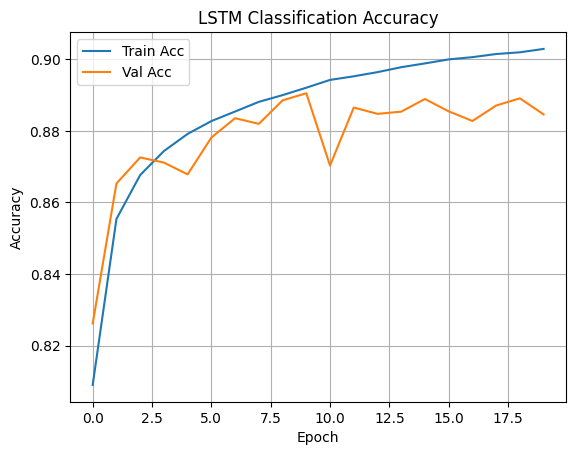

In [ ]:
if (MODE == 0 or MODE == 1 or MODE == 2 or MODE == 3 or MODE == 4 or MODE == 5 or MODE == 6 or MODE == 7 or MODE == 8):
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
elif (MODE == 10):
    plt.plot(history.history['masked_accuracy'], label='Train Acc')
    plt.plot(history.history['val_masked_accuracy'], label='Val Acc')

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.title("LSTM Classification Accuracy")
plt.show()

# Test Validation

211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
📊 Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.95      0.88      1723
           1       0.93      0.78      0.85       906
           2       0.76      0.95      0.84       482
           3       0.96      0.82      0.88       820
           4       0.92      0.94      0.93      2142
           5       0.90      0.68      0.78       655

    accuracy                           0.88      6728
   macro avg       0.88      0.85      0.86      6728
weighted avg       0.89      0.88      0.88      6728



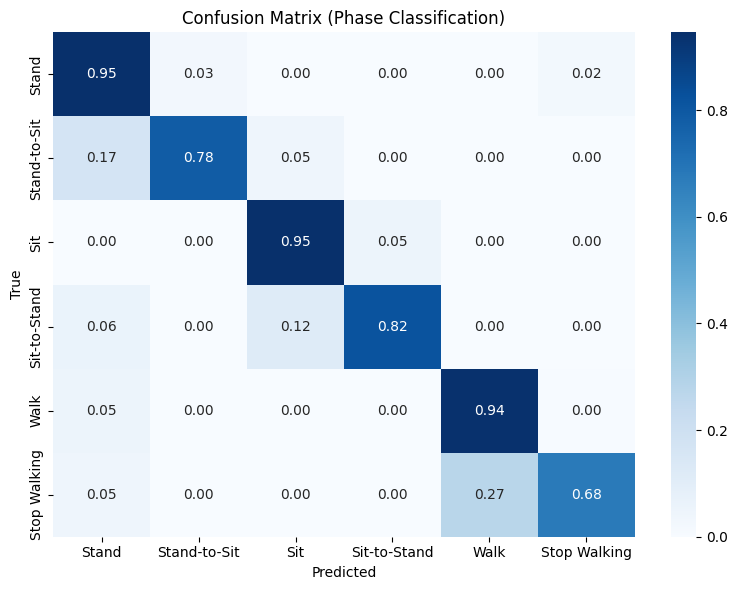

In [10]:
int_to_phase = {v: k for k, v in phase_to_int.items()}
class_names = [int_to_phase[i] for i in range(len(int_to_phase))]
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)
# y_pred[y_test == -1] = -1       ## 미라벨구간 

print("📊 Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Confusion Matrix with Probability
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)                    # 개수
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)       # 확률
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Phase Classification)")
plt.tight_layout()
plt.show()

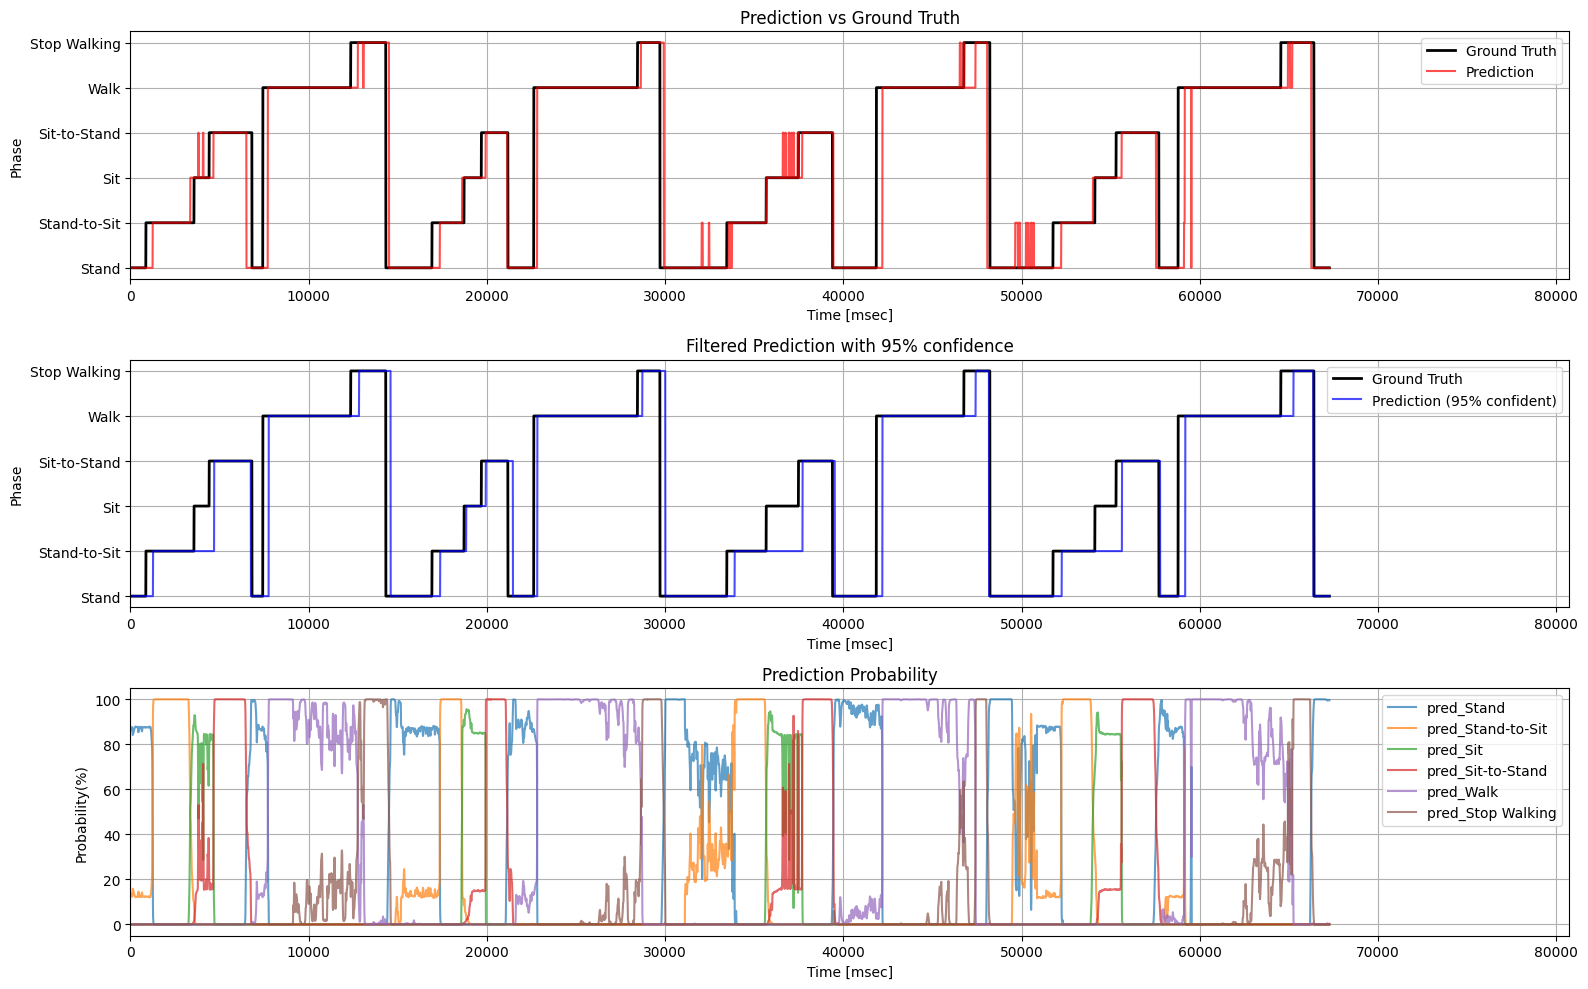

In [11]:
# 시간 축 생성
t = np.arange(len(y_test)) * 10  # 10 msec 단위

plt.figure(figsize=(16, 10))

# --------- subplot 1 ---------
plt.subplot(3, 1, 1)

# 정답 (검정색)
plt.plot(t, y_test, label='Ground Truth', color='black', linewidth=2)

# 예측 (빨간색)
plt.plot(t, y_pred, label='Prediction', color='red', linewidth=1.5, alpha=0.7)

# Phase 라벨
plt.yticks(ticks=list(phase_to_int.values()), labels=list(phase_to_int.keys()))
plt.xlabel("Time [msec]")
plt.ylabel("Phase")
plt.title("Prediction vs Ground Truth")

# x축 범위를 넉넉하게 설정 (예: 끝에서 20% 여유 주기)
x_margin = int(0.2 * t[-1])
plt.xlim([t[0], t[-1] + x_margin])

plt.legend(loc='upper right')
plt.grid(True)


# --------- subplot 2 ---------
plt.subplot(3, 1, 2)

# 정답 (검정색)
plt.plot(t, y_test, label='Ground Truth', color='black', linewidth=2)

# x% 이상 확률이 아닌 경우 이전 값을 유지 (스무딩)
percentage = 95
y_pred_mod = y_pred.copy()
conf_mask = (y_pred_probs.max(axis=1) >= (percentage / 100))
for i in range(1, len(y_pred_mod)):
    if not conf_mask[i]:
        y_pred_mod[i] = y_pred_mod[i - 1]

# 스무딩된 예측 (빨간색)
plt.plot(t, y_pred_mod, label=f'Prediction ({percentage}% confident)', color='Blue', linewidth=1.5, alpha=0.7)

# Phase 라벨
plt.yticks(ticks=list(phase_to_int.values()), labels=list(phase_to_int.keys()))
plt.xlabel("Time [msec]")
plt.ylabel("Phase")
plt.title(f"Filtered Prediction with {percentage}% confidence")

# x축 범위를 넉넉하게 설정 (예: 끝에서 20% 여유 주기)
x_margin = int(0.2 * t[-1])
plt.xlim([t[0], t[-1] + x_margin])

plt.legend(loc='upper right')
plt.grid(True)


# --------- subplot 3 ---------
plt.subplot(3, 1, 3)

# 각 클래스별 예측 확률
for i, phase in enumerate(phase_to_int.keys()):
    plt.plot(t, y_pred_probs[:, i] * 100, label=f'pred_{phase}', linewidth=1.5, alpha=0.7)

# Phase 라벨
plt.xlabel("Time [msec]")
plt.ylabel("Probability(%)")
plt.title("Prediction Probability")

# x축 범위를 넉넉하게 설정 (예: 끝에서 20% 여유 주기)
x_margin = int(0.2 * t[-1])
plt.xlim([t[0], t[-1] + x_margin])

plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()